# Lab 01 : Generate QM9/ZINC dataset for PyTorch and DGL

### Xavier Bresson <br>

**Smile datasets**: Molecule is represented with smile/RDKit. The files are in folder QM9_smile/train_smile.txt, val_smile.txt, test_smile.txt <br>
**PyTorch datasets**: Molecule is represented with PyTorch. The files are in folder QM9_pytorch/train_pytorch.pkl, val_pytorch.pkl, test_pytorch.pkl, atom_dict.pkl, bond_dict.pkl <br>
**DGL datasets**: Molecule is represented with DGL. The files are in folder QM9_dgl/train_dgl.pkl, val_dgl.pkl, test_dgl.pkl <br>

**PyTorch molecule structure**: A molecule object (our own class) that contains the following attributes:  
◦ molecule[idx].num_atom : nb of atoms, an integer (N)  
◦ molecule[idx].atom_type : pytorch tensor of size N, each element is an atom type, an integer between 0 and num_atom_type-1  
◦ molecule[idx].atom_type_pe : pytorch tensor of size N, each element is an atom type positional encoding, an integer between 0 and num_atom-1  
◦ molecule[idx].bond_type : pytorch tensor of size N x N, each element is a bond type, an integer between 0 and num_bond_type-1  
◦ molecule[idx].bag_of_atoms : pytorch tensor of size num_atom_type, histogram of atoms in the molecule  
◦ molecule[idx].logP_SA_cycle_normalized : the chemical property to regress, a pytorch float variable  
◦ molecule[idx].smile : the smile representation of the molecule for rdkit, a string   
◦ idx, an integer between 0 and num_molecules-1 representing the molecule index in the datasets  

**DGL molecule structure**: A DGL structure that contains the following members:   
◦ molecule[idx] : a tuple (dgl_graph, label) where label is logP_SA_cycle_normalized  
◦ dgl_graph : a DGL object that contains  
&nbsp; • sparse adjacency matrix  
&nbsp; • the node feature with dgl_graph.ndata['feat'] (atom_type)  
&nbsp; • the edge feature with dgl_graph.edata['feat'] (bond_type)    


**QM9 statistics** <br>
test set size : 5,000 <br>
val set size : 10,000 <br>
train set size : 118,879 <br>
min/max molecule size : 4/9<br>

**ZINC statistics** <br>
test set size :    5,000 <br>
val set size :    24,445 <br>
train set size : 220,011 <br>
min/max molecule size : 6/38 <br>


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/08_Datasets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl # Install DGL
    !pip install rdkit # Install RDKit


In [1]:
# Libraries
import os
import time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from utils import sascorer
import networkx as nx
import torch
from torch.utils.data import DataLoader
import pickle
import numpy as np
import dgl
import matplotlib.pyplot as plt


# Utility functions to process smile and generate pytorch molecules

In [2]:
# independent of having or not aromaticity
def clean_qm9_smiles(list_of_smiles):
    new_list_of_smiles = []
    for idx,smile in enumerate(list_of_smiles):
        # remove brakets and CH2
        smile = smile.replace('[C]', 'C')
        smile = smile.replace('[N]', 'N')
        smile = smile.replace('[O]', 'O')
        smile = smile.replace('[CH]', 'C')
        smile = smile.replace('[NH]', 'N')
        smile = smile.replace('[CH2]', 'C')
        # remove smile with non-connected compounds
        #if '.' in smile:
        #    continue
        # remove non-connected compounds in smiles 
        smile = sorted(smile.split('.'), key=len, reverse=True)[0]
        new_list_of_smiles.append(smile)
    return new_list_of_smiles

# independent of having or not aromaticity
def remove_stereo_smiles(list_of_smiles):
    for idx,smile in enumerate(list_of_smiles):
        smile = smile.replace('\\' , "")
        smile = smile.replace("/", "") 
        list_of_smiles[idx] = smile
    return list_of_smiles

def from_smile_to_rdkit_smile(smile):
    mol = Chem.MolFromSmiles(smile) # from arbitrary smile to mol
    smile = Chem.MolToSmiles(mol) # from mol to rdkit smile
    return smile

# remove aromatic bonds (smiles are changed)
def remove_aromatic_bonds(list_of_smiles):
    for idx,smile in enumerate(list_of_smiles): 
        mol = Chem.MolFromSmiles(smile)
        Chem.Kekulize(mol, clearAromaticFlags=True) # remove aromatic bonds
        smile = Chem.MolToSmiles(mol)
        list_of_smiles[idx] = smile
    return list_of_smiles

def atom2symbol(rdkit_atom):
    symbol = rdkit_atom.GetSymbol()
    num_explicit_h = rdkit_atom.GetNumExplicitHs()
    num_charges = rdkit_atom.GetFormalCharge()
    if num_explicit_h!=0:
        symbol = symbol + ' H' + str(num_explicit_h)
    if num_charges==1:
        symbol = symbol + ' +'
    if num_charges==-1:
        symbol = symbol + ' -'
    if abs(num_charges) > 1:
        'ERROR!: more than one charge'
    return symbol

# class of atom and bond dictionaries
class Dictionary:
    """
    word2idx and idx2word are mappings from words to idx and vice versa
    word2idx is a dictionary
    idx2word is a list
    word2num_occurence compute the number of times a given word has been added to the dictionary
    idx2num_occurence do the same, but with the index of the word rather than the word itself.
    """
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.word2num_occurence = {}
        self.idx2num_occurence = []
    def add_word(self, word):
        if word not in self.word2idx:
            # dictionaries
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
            # stats
            self.idx2num_occurence.append(0)
            self.word2num_occurence[word] = 0
        # increase counters    
        self.word2num_occurence[word]+=1
        self.idx2num_occurence[  self.word2idx[word]  ] += 1
    def get_rid_of_rare_words(self, min_num_occurence):
        new_idx2word = [ word for word in self.idx2word if self.word2num_occurence[word] >= min_num_occurence  ]
        new_word2idx = { word: idx  for idx,word in enumerate(new_idx2word) }         
        new_idx2num_occurence = [ self.word2num_occurence[word] for word in new_idx2word]   
        new_word2num_occurence = { word: self.word2num_occurence[word]  for word in new_idx2word } 
        self.word2idx = new_word2idx
        self.idx2word = new_idx2word
        self.word2num_occurence = new_word2num_occurence
        self.idx2num_occurence = new_idx2num_occurence
    def show(self):
        for idx, word in enumerate(self.idx2word):
            print(idx,'\t', word,'\t number of occurences = {}'.format(self.idx2num_occurence[idx]))
    def __len__(self):
        return len(self.idx2word)
    
# take a lists of smiles and use it to augment existing atom and bond dictionaries
def augment_dictionary(atom_dict, bond_dict, list_of_smiles ):
    for idx,smile in enumerate(list_of_smiles):
        mol = Chem.MolFromSmiles(smile)
        Chem.Kekulize(mol, clearAromaticFlags=True) # remove aromatic bonds
        for atom in mol.GetAtoms():
            atom_dict.add_word( atom2symbol(atom) )
        for bond in mol.GetBonds():
            bond_dict.add_word( str(bond.GetBondType()) )

# take three lists of smiles (train, val and test) and build atoms and bond dictionaries
def make_dictionary(list_of_smiles_train, list_of_smiles_val, list_of_smiles_test):
    atom_dict = Dictionary()
    bond_dict = Dictionary()
    bond_dict.add_word('NONE')
    print('test..')
    augment_dictionary(atom_dict, bond_dict, list_of_smiles_test )
    print('val..')
    augment_dictionary(atom_dict, bond_dict, list_of_smiles_val )  
    print('train..')
    augment_dictionary(atom_dict, bond_dict, list_of_smiles_train )
    return atom_dict, bond_dict       

# NOT independent of the property of aromaticity
def contain_OOV_atom(smile, atom_dict ): 
    mybool = False
    mol = Chem.MolFromSmiles(smile) 
    Chem.Kekulize(mol, clearAromaticFlags=True) # MUST remove aromatic bonds for OOV
    for atom in mol.GetAtoms():
        if atom2symbol(atom) not in atom_dict.word2idx:
            mybool=True
    return mybool

# independent of having or not aromaticity
def get_rid_of_OOV_smiles(list_of_smiles, atom_dict ):
    new_list = []
    OOV_list = []
    for smiles in list_of_smiles:
        if contain_OOV_atom(smiles, atom_dict ):
            OOV_list.append(smiles)
        else:
            new_list.append(smiles)   
    return new_list, OOV_list

# logP
def logP(mol):
    logp = Descriptors.MolLogP(mol)
    return logp

# SA  
def SA(mol):
    sa = sascorer.calculateScore(mol)
    return sa

# cycle
def compute_cycle(smile):
    cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(Chem.MolFromSmiles(smile))))
    if len(cycle_list) == 0:
        cycle_length = 0
    else:
        cycle_length = max([ len(j) for j in cycle_list ])
    if cycle_length <= 6:
        cycle_length = 0
    else:
        cycle_length = cycle_length - 6
    cycle_score = -cycle_length
    return cycle_score

def Cycle(mol):
    smile = Chem.MolToSmiles(mol) # mol is supposed to be a valid rdkit molecule
    cycle = float(compute_cycle(smile))
    return cycle

def logP_SA(mol):
    logp = logP(mol)
    sa = SA(mol)
    return logp - sa

def compute_stat_chem_prop_train_mol(smile_train):
    logP_values = []
    SA_values = []
    cycle_values = []
    for smile in smile_train: 
        mol = Chem.MolFromSmiles(smile)
        logP_values.append(logP(mol))
        SA_values.append(-SA(mol))
        cycle_values.append(Cycle(mol))
    # stats
    logP_values = torch.tensor(logP_values)
    logP_values_mean = logP_values.mean().item()
    logP_values_std = logP_values.std().item()
    SA_values = torch.tensor(SA_values)
    SA_values_mean = SA_values.mean().item()
    SA_values_std = SA_values.std().item()
    cycle_values = torch.tensor(cycle_values)
    cycle_values_mean = cycle_values.mean().item()
    cycle_values_std = cycle_values.std().item()
    train_stat_mol_prop = [logP_values_mean, logP_values_std, SA_values_mean, SA_values_std, cycle_values_mean, cycle_values_std]
    return train_stat_mol_prop

class Molecule:
    """
    A molecule object contains the following attributes:
        ; molecule.num_atom : nb of atoms, an integer (N)
        ; molecule.atom_type : pytorch tensor of size N, each element is an atom type, an integer between 0 and num_atom_type-1
        ; molecule.atom_type_pe : pytorch tensor of size N, each element is an atom type positional encoding, an integer between 0 and num_atom-1
        ; molecule.bond_type : pytorch tensor of size N x N, each element is a bond type, an integer between 0 and num_bond_type-1 
        ; molecule.bag_of_atoms : pytorch tensor of size num_atom_type, histogram of atoms in the molecule
        ; molecule.logP_SA_cycle_normalized : the chemical property to regress, a pytorch float variable
        ; molecule.smile : the smile representation of the molecule for rdkit, a string   
    """
    def __init__(self, num_atom, num_atom_type):
        self.num_atom       = num_atom
        self.atom_type      = torch.zeros( num_atom , dtype=torch.long )
        self.atom_type_pe   = torch.zeros( num_atom , dtype=torch.long )
        self.bond_type      = torch.zeros( num_atom , num_atom, dtype=torch.long )
        self.bag_of_atoms   = torch.zeros( num_atom_type, dtype=torch.long)
        self.logP_SA        = torch.zeros( 1, dtype=torch.float)
        self.logP_SA_cycle_normalized  = torch.zeros( 1, dtype=torch.float)
        self.smile  = ''
    def set_bag_of_atoms(self):
        for tp in self.atom_type:
                self.bag_of_atoms[tp.item()] += 1
    def set_atom_type_pe(self):
        histogram={}
        for idx, tp in enumerate(self.atom_type):
            tpp=tp.item()
            if tpp not in histogram:
                histogram[tpp] = 0
            else:
                histogram[tpp] += 1
            self.atom_type_pe[idx] = histogram[tpp]
    def shuffle_indexing(self):
        idx = torch.randperm(self.num_atom)
        self.atom_type = self.atom_type[idx]
        self.atom_type_pe = self.atom_type_pe[idx]
        self.bond_type = self.bond_type[idx][:,idx]
        return idx
    def __len__(self):
        return self.num_atom
    
# convert smile molecule to pytorch molecule 
def from_smile_to_pymol(smile, atom_dict, bond_dict, stat_prop, remove_aromatic=False):
    """
    This function take a smile an create a "pytorch molecule". 
    In order to do this we need to have some mapping between 
    type of atom and integers, and type of bonds an integer.
    (see dictionary class below)

    Input: a smile 
           a dictionary of atoms (that gives mapping of the type C --> 0, N --> 1, etc...)
           a dictionary of bonds (that gives mapping of the type SINGLE --> 0,  AROMATIC --> 1, etc...)
           
    Output: return a pytorch molecule
    """
    rdkit_mol = Chem.MolFromSmiles(smile)
    if remove_aromatic==True:
        Chem.Kekulize(rdkit_mol, clearAromaticFlags=True) # remove aromatic bonds
    N = rdkit_mol.GetNumAtoms()
    num_atom_type = len(atom_dict)
    pytorch_mol = Molecule(N,num_atom_type)   
    # set the bond_type attribute
    for bond in rdkit_mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type_idx=bond_dict.word2idx[ str(bond.GetBondType()) ]
        pytorch_mol.bond_type[i,j]= bond_type_idx
        pytorch_mol.bond_type[j,i]= bond_type_idx      
    # set the atom_type attribute
    for atom in rdkit_mol.GetAtoms():
        i=atom.GetIdx()
        pytorch_mol.atom_type[i]=atom_dict.word2idx[ atom2symbol(atom) ]      
    # set the atom_type_pe and bag of atoms attributes
    pytorch_mol.set_bag_of_atoms() 
    pytorch_mol.set_atom_type_pe()
    # set the target chemical property :  y(m) = logP(m) − SA(m) + cycle(m)
    rdkit_mol = Chem.MolFromSmiles(smile) # do *not* remove aromatic bonds when logP_SA is computed 
    pytorch_mol.logP_SA = torch.Tensor([logP_SA(rdkit_mol)]) 
    logP_values_mean = stat_prop[0] 
    logP_values_std = stat_prop[1]
    SA_values_mean = stat_prop[2]
    SA_values_std = stat_prop[3]
    cycle_values_mean = stat_prop[4]
    cycle_values_std = stat_prop[5]
    logP_value_normalized = (logP(rdkit_mol)-logP_values_mean)/logP_values_std
    SA_value_normalized = (-SA(rdkit_mol)-SA_values_mean)/SA_values_std
    cycle_value_normalized = (Cycle(rdkit_mol)-cycle_values_mean)/cycle_values_std
    logP_SA_cycle_normalized = logP_value_normalized + SA_value_normalized + cycle_value_normalized
    pytorch_mol.logP_SA_cycle_normalized = torch.Tensor([logP_SA_cycle_normalized])
    pytorch_mol.smile = smile
    return pytorch_mol

def symbol2atom(aug_symb):
    mylist=aug_symb.split()
    atom = Chem.Atom(mylist[0])
    if '+' in mylist:
        atom.SetFormalCharge(1)
    if '-' in mylist:
        atom.SetFormalCharge(-1)
    if 'H1' in mylist:
        atom.SetNumExplicitHs(1)   
    if 'H2' in mylist:
        atom.SetNumExplicitHs(2)    
    if 'H3' in mylist:
        atom.SetNumExplicitHs(3)
    return atom

def from_mol_to_smile(mol, remove_aromatic=False):
    if remove_aromatic==True:
        Chem.Kekulize(mol, clearAromaticFlags=True) # remove aromatic bonds
    smile = Chem.MolToSmiles(mol)
    return smile

def from_pymol_to_smile(pymol, atom_dict, bond_dict, remove_aromatic=False):
    N = pymol.num_atom 
    mol = Chem.RWMol()
    for tp in pymol.atom_type:
        symbol = atom_dict.idx2word[ tp.item() ]
        mol.AddAtom( symbol2atom(symbol) )
    for i in range(0,N): 
        for j in range(i+1,N): 
            tp = pymol.bond_type[i,j].item()
            bond_stg = bond_dict.idx2word[tp]
            if bond_stg!='NONE':
                if bond_stg=='SINGLE':
                    mol.AddBond(i, j, Chem.rdchem.BondType.SINGLE)
                if bond_stg=='DOUBLE':
                    mol.AddBond(i, j, Chem.rdchem.BondType.DOUBLE)
                if bond_stg=='TRIPLE':
                    mol.AddBond(i, j, Chem.rdchem.BondType.TRIPLE)
                if bond_stg=='AROMATIC':
                    #print('ISSUE: MUST BE NO AROMATIC BONDS !!!!')
                    mol.AddBond(i, j, Chem.rdchem.BondType.AROMATIC)
    smile = from_mol_to_smile(mol,remove_aromatic)
    return smile

def rm_stereo(smile, remove_aromatic=False):
    smile = smile.replace('\\' , "")
    smile = smile.replace("/", "") 
    mol = Chem.MolFromSmiles(smile)
    if remove_aromatic==True:
        Chem.Kekulize(mol, clearAromaticFlags=True) # remove aromatic bonds
    smile = Chem.MolToSmiles(mol, isomericSmiles=False) # remove stereo
    return smile


# Generate pytorch datasets from original smile datasets 
Note: I do not use the full datasets for the course, only a subset.

In [3]:
start=time.time()

# folders
data_folder_smile = 'QM9_smile'
data_folder_pytorch = 'QM9_pytorch' 
# data_folder_smile = 'ZINC_smile'
# data_folder_pytorch = 'ZINC_pytorch' 

print('Convert csv files to panda dataframes')
df_train = pd.read_csv(data_folder_smile + '/train_smile.txt')
df_val = pd.read_csv(data_folder_smile +'/valid_smile.txt')
df_test = pd.read_csv(data_folder_smile + '/test_smile.txt')
# df_train = pd.read_csv(data_folder_smile + '/test_smile.txt') # DEBUG !
# df_val = pd.read_csv(data_folder_smile +'/test_smile.txt')   # DEBUG !
# df_test = pd.read_csv(data_folder_smile + '/test_smile.txt')  # DEBUG !
print(df_test[:5])

print('Extract subsets of datasets') # comment the following lines to use full datasets <==========
                                     # Subsets are for teaching purpose
df_train = df_train[:2000] # truncated dataset !
df_val = df_val[:200]      # truncated dataset !
df_test = df_test[:200]    # truncated dataset !
print(df_test[:5])

print('Convert the panda data frame into a list of smiles')
smile_train = [ df_train.loc[i,'smiles'] for i in df_train.index  ]
smile_val   = [ df_val.loc[i,'smiles']   for i in df_val.index    ]
smile_test  = [ df_test.loc[i,'smiles']  for i in df_test.index   ]
print(smile_test[:5])

# Change QM9 smiles : [C]=>C, [N]=>N, [O]=>O, [CH]=>C, [NH]=>N
print('clean QM9 smiles')
smile_train = clean_qm9_smiles(smile_train)
smile_val = clean_qm9_smiles(smile_val)
smile_test = clean_qm9_smiles(smile_test) 
print(smile_test[:5]) 

# Clean stereo smiles
print('remove stereo symbols in smiles')
smile_train = remove_stereo_smiles(smile_train)
smile_val = remove_stereo_smiles(smile_val)
smile_test = remove_stereo_smiles(smile_test)   
print(smile_test[:5]) 

print('Change original smiles to rdkit-smiles')
smile_train = [ from_smile_to_rdkit_smile(smile) for smile in smile_train ]
smile_val =   [ from_smile_to_rdkit_smile(smile) for smile in smile_val ]
smile_test =  [ from_smile_to_rdkit_smile(smile) for smile in smile_test ]
print(smile_test[:5]) 

print('Remove aromatic bonds')
smile_train = remove_aromatic_bonds(smile_train)
smile_val = remove_aromatic_bonds(smile_val)
smile_test = remove_aromatic_bonds(smile_test)
print(smile_test[:5]) 

# Use the lists of smiles to build dictionaries of atoms and bonds
print('Building atom and bond dictionaries..')
atom_dict, bond_dict = make_dictionary(smile_train, smile_val, smile_test)
atom_dict.show()
print(atom_dict.idx2word)
print(atom_dict.word2idx)
print(bond_dict.idx2word)
print(bond_dict.word2idx)

# Trim dataset
print('Get rid of rare coumpounds and only keep the following') 
#atom_dict.get_rid_of_rare_words(100) # if this line is commented then all coumpounds are kept
                                      # comment out for getting rid of rare coumpounds with threshold frequency
atom_dict.show()

print('Get rid of OOV smiles..')
smile_test,  OOV_smile_test  = get_rid_of_OOV_smiles( smile_test,  atom_dict )
print('test set size : \t {} ({} were discarded)'.format( len(smile_test) ,  len(OOV_smile_test)) )
smile_val,   OOV_smile_val   = get_rid_of_OOV_smiles( smile_val,   atom_dict )
print('val set size : \t {} ({} were discarded)'.format( len(smile_val) ,  len(OOV_smile_val)) )
smile_train, OOV_smile_train = get_rid_of_OOV_smiles( smile_train, atom_dict )
print('train set size : \t {} ({} were discarded)'.format( len(smile_train) ,  len(OOV_smile_train)) )
        
# Compute chemical properties of train molecules (logP, SA, cycle)  
print('Compute statistical chemical properties of train molecules')
train_stat_mol_prop = compute_stat_chem_prop_train_mol(smile_train)
print('logP_values_mean, logP_values_std, SA_values_mean, SA_values_std, cycle_values_mean, cycle_values_std:\n',train_stat_mol_prop)

# Convert the lists of smiles into lists of pytorch molecules
print('Convert smiles to pytorch molecules...')
stat = train_stat_mol_prop
print('test..')
test  = [ from_smile_to_pymol(smile,atom_dict,bond_dict,stat,True) for smile in smile_test  ]
#test  = [ Smiles2Mol(smile , atom_dict, bond_dict) for smile in smile_test  ]
print('val..')
val   = [ from_smile_to_pymol(smile,atom_dict,bond_dict,stat,True) for smile in smile_val   ]
#val   = [ Smiles2Mol(smile , atom_dict, bond_dict) for smile in smile_val   ]
print('train..')
train = [ from_smile_to_pymol(smile,atom_dict,bond_dict,stat,True) for smile in smile_train ]
#train = [ Smiles2Mol(smile , atom_dict, bond_dict) for smile in smile_train ]
print(test[0].atom_type)
print(test[0].atom_type_pe)
print(test[0].bond_type)
print(test[0].bag_of_atoms)
print(test[0].smile)
# properties given molecules : 
# logP : water-octanal partition coefficient
# SA : synthetic accessibility score
# QED : Qualitative Estimate of Drug-likeness
# logP_SA = logP − SA
print('logP_SA',test[0].logP_SA)
print('logP_SA_cycle_normalized',test[0].logP_SA_cycle_normalized)
print('smile_test',smile_test[0])

# Sanity check : smile => pytorch => smile
print('Sanity check: convert pytorch molecules back to smiles and check we recover the original smiles')
print('test..')
smile_test2  = [ from_pymol_to_smile(pymol,atom_dict,bond_dict,True) for pymol in test  ]
print('val..')
smile_val2  = [ from_pymol_to_smile(pymol,atom_dict,bond_dict,True) for pymol in val  ]
print('train..')
smile_train2  = [ from_pymol_to_smile(pymol,atom_dict,bond_dict,True) for pymol in train  ]
print(smile_test[:5]) 
print(smile_test2[:5]) 
def accuracy_btw_smiles(smiles_list1, smiles_list2):
    count=0
    for idx,sm in enumerate(smiles_list1):
        if rm_stereo(sm,True) == smiles_list2[idx]:
            count+=1
            #print('idx:',idx,' Smile:',rm_stereo(sm),' Smile=>mol=>smile:',smiles_list2[idx])
        else:
            #print('')
            print('idx:',idx,' Smile:',rm_stereo(sm),' Smile=>mol=>smile:',smiles_list2[idx])
    return count/len(smiles_list1)
acc_test = accuracy_btw_smiles(smile_test, smile_test2)
acc_val = accuracy_btw_smiles(smile_val, smile_val2)
acc_train = accuracy_btw_smiles(smile_train, smile_train2)
print('percentage of correct smiles --> pytorch molecules --> smiles: test/val/train {}%/{}%/{}%'.format(
    acc_test*100, acc_val*100, acc_train*100))

# Saving
print('Saving pytorch molecules to folder : ' + data_folder_pytorch )
os.system("mkdir " + data_folder_pytorch )
with open(data_folder_pytorch + "/atom_dict.pkl","wb") as f:
    pickle.dump(atom_dict,f)
with open(data_folder_pytorch + "/bond_dict.pkl","wb") as f:
    pickle.dump(bond_dict, f)
with open(data_folder_pytorch + "/test_pytorch.pkl","wb") as f:
    pickle.dump(test,f)
with open(data_folder_pytorch +  "/val_pytorch.pkl","wb") as f:
    pickle.dump(val,f)
with open(data_folder_pytorch +  "/train_pytorch.pkl","wb") as f:
    pickle.dump(train,f)
print('Time:',time.time()-start)
print('Done!')


Convert csv files to panda dataframes
                  smiles
0  N[C]1[N]C2CC1[N][C]2N
1            CCn1cncc1OC
2          OC1CCCCC(O)C1
3         CCC1C2OCC12C=O
4       CN1C(=O)CN=C1C=O
Extract subsets of datasets
                  smiles
0  N[C]1[N]C2CC1[N][C]2N
1            CCn1cncc1OC
2          OC1CCCCC(O)C1
3         CCC1C2OCC12C=O
4       CN1C(=O)CN=C1C=O
Convert the panda data frame into a list of smiles
['N[C]1[N]C2CC1[N][C]2N', 'CCn1cncc1OC', 'OC1CCCCC(O)C1', 'CCC1C2OCC12C=O', 'CN1C(=O)CN=C1C=O']
clean QM9 smiles
['NC1NC2CC1NC2N', 'CCn1cncc1OC', 'OC1CCCCC(O)C1', 'CCC1C2OCC12C=O', 'CN1C(=O)CN=C1C=O']
remove stereo symbols in smiles
['NC1NC2CC1NC2N', 'CCn1cncc1OC', 'OC1CCCCC(O)C1', 'CCC1C2OCC12C=O', 'CN1C(=O)CN=C1C=O']
Change original smiles to rdkit-smiles
['NC1NC2CC1NC2N', 'CCn1cncc1OC', 'OC1CCCCC(O)C1', 'CCC1C2OCC12C=O', 'CN1C(=O)CN=C1C=O']
Remove aromatic bonds
['NC1NC2CC1NC2N', 'CCN1C=NC=C1OC', 'OC1CCCCC(O)C1', 'CCC1C2OCC12C=O', 'CN1C(=O)CN=C1C=O']
Building atom and bond 

mkdir: QM9_pytorch: File exists


Time: 34.284770011901855
Done!


# Print pytorch molecule and visualize with rdkit

CN1C(=O)CN=C1C=O
tensor([1, 0, 1, 2, 1, 0, 1, 1, 2])
tensor([0, 0, 1, 0, 2, 1, 3, 4, 1])
9
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 2, 1, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 2, 0, 0],
        [0, 1, 0, 0, 0, 2, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 2],
        [0, 0, 0, 0, 0, 0, 0, 2, 0]])
tensor([2, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([-0.4989])
CN1C(=O)CN=C1C=O


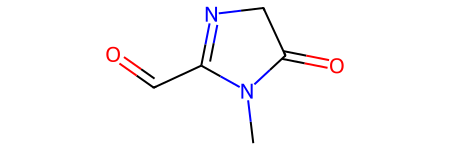

In [4]:
idx = 4

print(test[idx].smile)
print(test[idx].atom_type)
print(test[idx].atom_type_pe)
print(test[idx].num_atom)
print(test[idx].bond_type)
print(test[idx].bag_of_atoms)
print(test[idx].logP_SA_cycle_normalized)
print(test[idx].smile)

mol = Chem.MolFromSmiles(test[idx].smile)
mol


# Loading pytorch datasets

In [5]:
print('Loading data...')
start = time.time()

data_folder_pytorch = 'QM9_pytorch/'
# data_folder_pytorch = 'ZINC_pytorch/'
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"test_pytorch.pkl","rb") as f:
    test=pickle.load(f)
with open(data_folder_pytorch+"val_pytorch.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    train=pickle.load(f)
print('Time:',time.time()-start)

print(atom_dict.idx2word)
print(atom_dict.word2idx)
print(bond_dict.idx2word)
print(bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 45
print(train[idx].atom_type)
print(train[idx].atom_type_pe)
print(train[idx].bond_type)
print(train[idx].bag_of_atoms)
print(train[idx].logP_SA_cycle_normalized)
print(train[idx].smile)


Loading data...
QM9_pytorch/
Time: 1.2087969779968262
['N', 'C', 'O', 'F', 'N H3 +', 'O -', 'C H1 -', 'N +', 'N -', 'N H1 -', 'C +', 'O +', 'N H2 +']
{'N': 0, 'C': 1, 'O': 2, 'F': 3, 'N H3 +': 4, 'O -': 5, 'C H1 -': 6, 'N +': 7, 'N -': 8, 'N H1 -': 9, 'C +': 10, 'O +': 11, 'N H2 +': 12}
['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
{'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
13 4
tensor([1, 1, 2, 1, 1, 1, 1])
tensor([0, 1, 0, 2, 3, 4, 5])
tensor([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0]])
tensor([0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1.5990])
CC(O)C1CC1C


# Dataset statistics

In [6]:
# Organize data into group of of molecules of fixed sized
# For example, train is a dictionary
# And train[22] is a list containing all the molecules of size 22  
print("Organizing molecules per size...")

def group_molecules_per_size(dataset):
    mydict={}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)]=[]
        mydict[len(mol)].append(mol)
    return mydict

test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)
print(len(train_group[8])) # QM9
# print(len(train_group[28])) # ZINC


Organizing molecules per size...
282


In [7]:
# what is the biggest molecule in the train set
max_mol_sz= max(list( train_group.keys()))
print('Max num atoms = ', max_mol_sz)


Max num atoms =  9


In [8]:
# distribution w.r.t. molecule size
print('Train')
data = train_group
for nb_atom in range(max_mol_sz+1):
    try: 
        print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
    except:
        pass
print('Val')
data = val_group
for nb_atom in range(max_mol_sz+1):
    try: 
        print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
    except:
        pass
print('Test')
data = test_group
for nb_atom in range(max_mol_sz+1):
    try: 
        print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
    except:
        pass
    

Train
number of molecule of size 4: 	 2
number of molecule of size 5: 	 2
number of molecule of size 6: 	 13
number of molecule of size 7: 	 37
number of molecule of size 8: 	 282
number of molecule of size 9: 	 1664
Val
number of molecule of size 7: 	 6
number of molecule of size 8: 	 28
number of molecule of size 9: 	 166
Test
number of molecule of size 6: 	 1
number of molecule of size 7: 	 3
number of molecule of size 8: 	 37
number of molecule of size 9: 	 159


# Generate batch of pytorch molecules of same size

In [9]:
# A class to help drawing batches of molecules having the same size
class MoleculeSampler:
    """
    The dataset is a dictionary where the keys are the molecule sizes, and
    the values are lists of pytorch molecule of the given size.
    The MoleculeSampler will choose a size at random, and then provide the bs indices
    of the molecules of this size to be drawn.

    ATTRIBUTE:

    bs: batch size

    num_mol: (dictionary) key = size 
                          value = number of molecules of this size

    counter: (dictionary) key   = size
                          value = number of molecules of this size that have already been processed

    order:   (dictionary) key = size
                                value= np-array describing in which order 
                                       the molecules of this given size are going to be vistited                         
    """
    
    def __init__(self, organized_dataset, bs , shuffle=True):  
        self.bs=bs
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.counter = { sz: 0   for sz in organized_dataset }
        if shuffle:
            self.order = { sz: np.random.permutation(num)  for sz , num in self.num_mol.items() }
        else:
            self.order = { sz: np.arange(num)  for sz , num in self.num_mol.items() } 


    def compute_num_batches_remaining(self):
        return {sz:  ( self.num_mol[sz] - self.counter[sz] ) // self.bs  for sz in self.num_mol}

    def choose_molecule_size(self):
        num_batches= self.compute_num_batches_remaining()
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   ) 
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz

    def is_empty(self):
        num_batches= self.compute_num_batches_remaining()
        return sum( num_batches.values() ) == 0

    def draw_batch_of_molecules(self,sz):  
        indices=self.order[sz][ self.counter[sz] : self.counter[sz] + self.bs]
        self.counter[sz] += self.bs  
        return indices
    

In [10]:
bs = 50
sampler = MoleculeSampler(train_group, bs)

# get a batch
sz = sampler.choose_molecule_size()
print(sz)
indices = sampler.draw_batch_of_molecules(sz) 
print(indices)
minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] )
print(minibatch_node.size())
minibatch_pe  = torch.stack( [ train_group[sz][i].atom_type_pe  for i in indices] )
print(minibatch_pe.size())
minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] )
print(minibatch_edge.size())
minibatch_boa = torch.stack( [ train_group[sz][i].bag_of_atoms for i in indices] )
print(minibatch_boa.size())
minibatch_logP_SA_cycle_normalized = torch.stack( [ train_group[sz][i].logP_SA_cycle_normalized for i in indices] )
print(minibatch_logP_SA_cycle_normalized.size())


9
[1004  815 1065    1  836 1257  308  520  145  855   58  716  476  108
 1245  562  773 1599   98  536  590  916 1300 1524 1089 1640  446  513
  149  468  190  819 1303  872  584 1547  537  273  367  548  191   94
  307   76 1334 1542   31  609  593  680]
torch.Size([50, 9])
torch.Size([50, 9])
torch.Size([50, 9, 9])
torch.Size([50, 13])
torch.Size([50, 1])


# Re-loading pytorch molecules (sanity check)

In [11]:
print('Loading data...')
start=time.time()

data_folder_pytorch = 'QM9_pytorch/'
# data_folder_pytorch = 'ZINC_pytorch/'
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"test_pytorch.pkl","rb") as f:
    test=pickle.load(f)
with open(data_folder_pytorch+"val_pytorch.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    train=pickle.load(f)
print('Time:',time.time()-start)

print(atom_dict.idx2word)
print(atom_dict.word2idx)
print(bond_dict.idx2word)
print(bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 45
print(train[idx].atom_type)
print(train[idx].atom_type_pe)
print(train[idx].bond_type)
print(train[idx].bag_of_atoms)
print(train[idx].logP_SA_cycle_normalized)
print(train[idx].smile)


Loading data...
QM9_pytorch/
Time: 1.1888618469238281
['N', 'C', 'O', 'F', 'N H3 +', 'O -', 'C H1 -', 'N +', 'N -', 'N H1 -', 'C +', 'O +', 'N H2 +']
{'N': 0, 'C': 1, 'O': 2, 'F': 3, 'N H3 +': 4, 'O -': 5, 'C H1 -': 6, 'N +': 7, 'N -': 8, 'N H1 -': 9, 'C +': 10, 'O +': 11, 'N H2 +': 12}
['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
{'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
13 4
tensor([1, 1, 2, 1, 1, 1, 1])
tensor([0, 1, 0, 2, 3, 4, 5])
tensor([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0]])
tensor([0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1.5990])
CC(O)C1CC1C


# Utility functions to generate DGL molecules

In [12]:
class MoleculeDGL(torch.utils.data.Dataset):
    def __init__(self, data_dir, split):
        self.split = split
        with open(data_dir + "/%s_pytorch.pkl" % split,"rb") as f:
            self.data = pickle.load(f)
        num_graphs = len(self.data)
        self.graph_lists = []
        self.graph_labels = []
        self.num_graphs = num_graphs
        self._prepare()
    def _prepare(self):
        print("preparing %d graphs for the %s set..." % (self.num_graphs, self.split.upper()))
        for molecule in self.data:
            node_features = molecule.atom_type.long()
            adj = molecule.bond_type
            edge_list = (adj != 0).nonzero() # converting adj matrix to edge_list
            edge_idxs_in_adj = edge_list.split(1, dim=1)
            edge_features = adj[edge_idxs_in_adj].reshape(-1).long()
            # version 2020 -- tmp
            #g = dgl.DGLGraph() # create the DGL graph
            #g.add_nodes(molecule.num_atom)
            #for src, dst in edge_list:
            #    g.add_edges(src.item(), dst.item())  
            # version 2023
            g = dgl.graph((edge_list[:,0], edge_list[:,1]), num_nodes=molecule.num_atom) # create the DGL graph  
            g.ndata['feat'] = node_features
            g.edata['feat'] = edge_features
            self.graph_lists.append(g)
            self.graph_labels.append(molecule.logP_SA_cycle_normalized)
    def __len__(self):
        return self.num_graphs
    def __getitem__(self, idx):
        return self.graph_lists[idx], self.graph_labels[idx]
    
class MoleculeDatasetDGL(torch.utils.data.Dataset):
    def __init__(self, data_name, data_dir):
        t0 = time.time()
        print('dataset: %s' % data_name)
        with open(data_dir + "/atom_dict.pkl" ,"rb") as f: atom_dict = pickle.load(f)
        with open(data_dir + "/bond_dict.pkl" ,"rb") as f: bond_dict = pickle.load(f)
        self.num_atom_type = len(atom_dict)
        self.num_bond_type = len(bond_dict)
        self.train = MoleculeDGL(data_dir, 'train')
        self.val   = MoleculeDGL(data_dir, 'val')
        self.test  = MoleculeDGL(data_dir, 'test')
        print("Time taken: {:.4f}s".format(time.time()-t0))


# Generate DGL datasets from pytorch datasets

In [13]:
start = time.time() 

# Convert pytorch to dgl format
dataset_name = 'QM9'
# dataset_name = 'ZINC'
dataset = MoleculeDatasetDGL(dataset_name, data_folder_pytorch) 

print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

idx = 0
print(dataset.train[idx])
print(dataset.val[idx])
print(dataset.test[idx])

# Saving
data_folder_dgl = 'QM9_dgl/'
# data_folder_dgl = 'ZINC_dgl/'
print('Saving dgl molecules to folder : ' + data_folder_dgl )
os.system("mkdir " + data_folder_dgl )
with open(data_folder_dgl + "/test_dgl.pkl","wb") as f:
    pickle.dump(dataset.test,f)
with open(data_folder_dgl +  "/val_dgl.pkl","wb") as f:
    pickle.dump(dataset.val,f)
with open(data_folder_dgl +  "/train_dgl.pkl","wb") as f:
    pickle.dump(dataset.train,f)
print('Time:',time.time()-start)
print('Done!')


dataset: QM9
preparing 2000 graphs for the TRAIN set...
preparing 200 graphs for the VAL set...
preparing 200 graphs for the TEST set...
Time taken: 1.6281s
2000
200
200
(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-0.2620]))
(Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([0.5061]))
(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-4.4335]))
Saving dgl molecules to folder : QM9_dgl/


mkdir: QM9_dgl/: File exists


Time: 3.588580846786499
Done!


# Utility class for loading DGL datasets

In [14]:
class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, data_name, data_dir):
        start = time.time()
        print("Loading datasets %s_dgl..." % (data_name))
        with open(data_dir + 'train_dgl.pkl',"rb") as f:
            self.train = pickle.load(f)
        with open(data_dir + 'val_dgl.pkl',"rb") as f:
            self.val = pickle.load(f)
        with open(data_dir + 'test_dgl.pkl',"rb") as f:
            self.test = pickle.load(f)
        print('train, test, val sizes :',len(self.train),len(self.test),len(self.val))
        print("Time: {:.4f}s".format(time.time()-start))
    # form a mini batch from a given list of samples = [(graph, label) pairs]
    # collate requires a method __getitem__ in the graph class used
    def collate(self, samples):
        # Input sample is a list of pairs (graph, label)
        graphs, labels = map(list, zip(*samples))
        batch_graphs = dgl.batch(graphs)
        batch_labels = torch.stack(labels)
        # Normalization w.r.t. graph sizes
        tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
        tab_norm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
        batch_norm_n = torch.cat(tab_norm_n).sqrt()  
        tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))]
        tab_norm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
        batch_norm_e = torch.cat(tab_norm_e).sqrt()
        return batch_graphs, batch_labels, batch_norm_n, batch_norm_e
    

# Loading DGL datasets

In [15]:
# Load the number of atom and bond types 
with open(data_folder_pytorch + "/atom_dict.pkl" ,"rb") as f: num_atom_type = len(pickle.load(f))
with open(data_folder_pytorch + "/bond_dict.pkl" ,"rb") as f: num_bond_type = len(pickle.load(f))
print(num_atom_type)
print(num_bond_type)

# Load the DGL datasets
dataset_name = 'QM9'
# dataset_name = 'ZINC'
datasets_dgl = MoleculeDataset(dataset_name, data_folder_dgl)
trainset, valset, testset = datasets_dgl.train, datasets_dgl.val, datasets_dgl.test

print(len(trainset))
print(len(valset))
print(len(testset))

idx = 0
print(trainset[:2])
print(valset[idx])
print(testset[idx])



13
4
Loading datasets QM9_dgl...
train, test, val sizes : 2000 200 200
Time: 2.3155s
2000
200
200
([Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})], [tensor([-0.2620]), tensor([1.0906])])
(Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([0.5061]))
(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-4.4335]))


# Generate batch of graphs (of different sizes) with DGL

In [16]:
batch_size = 100
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=datasets_dgl.collate)

batch_graphs, batch_labels, batch_norm_n, batch_norm_e = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
print(batch_norm_n.size())
print(batch_norm_e.size())

for iter, (batch_graphs, batch_labels, batch_norm_n, batch_norm_e) in enumerate(train_loader):
    print(iter)
    
batch_x = batch_graphs.ndata['feat']
print('batch_x',batch_x.size())
batch_e = batch_graphs.edata['feat']
print('batch_e',batch_e.size())
print('batch_norm_n',batch_norm_n.size())
print('batch_norm_e',batch_norm_e.size())


Graph(num_nodes=879, num_edges=1886,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})
[tensor([-1.2537]), tensor([1.3803]), tensor([-1.3044]), tensor([-1.4180]), tensor([-0.2478]), tensor([-0.9695]), tensor([-0.4222]), tensor([0.3878]), tensor([-1.0161]), tensor([0.0748]), tensor([-0.0517]), tensor([-2.5762]), tensor([-1.5588]), tensor([-0.9627]), tensor([-0.8684]), tensor([-0.7091]), tensor([0.6806]), tensor([-1.3069]), tensor([-0.8694]), tensor([-1.5657]), tensor([0.2832]), tensor([0.9774]), tensor([-0.0191]), tensor([0.9235]), tensor([0.3156]), tensor([0.7727]), tensor([-0.1822]), tensor([0.2102]), tensor([-1.6419]), tensor([-2.0087]), tensor([2.5527]), tensor([-8.9879]), tensor([2.2164]), tensor([1.7668]), tensor([2.1484]), tensor([0.6698]), tensor([0.0472]), tensor([2.2352]), tensor([-2.9537]), tensor([-0.3383]), tensor([0.8908]), tensor([-1.6415]), tensor([2.0142]), tensor([-1.0754]), tensor([2.36